# Resolución ejercicio 2.9.4
## Análisis y diseño de algoritmos distribuidos en redes
### Andrés Montoro 5.169.779-1

.Considere un grafo generico donde cada entidad x tiene un valor inicial v(x); estos valores no son necesariamente distintos. El rank de una entidad x será el rank de su valor, esto es, rank(x) = 1 + |{y en v:v( y ) < v( x )}| (la entidad que tenga el menor valor tendrá rank 1). Diseñe un protocolo eficiente para determinar el rank de todas las entidades, pruebe su correctitud y analice su complejidad. Implemente el protocolo en el simulador.

Se asume:
- Links bidireccionales
- Confiabilidad total
- Mensajes en orden
- Iniciador único

Asumimos también las siguientes restricciones:
- Conectividad
- Total reliability

In [ ]:
from pydistsim.algorithm.node_algorithm import NodeAlgorithm, StatusValues
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.restrictions.communication import BidirectionalLinks
from pydistsim.restrictions.reliability import TotalReliability
from pydistsim.restrictions.communication import MessageOrdering
from pydistsim.restrictions.topological import Connectivity, UniqueInitiator
import random

Q = "I'm your father"
YES = "You're Anakin Skywalker"
NO = "That's impossible!"


class Ranking(NodeAlgorithm):
    default_params = {
        "req_msj" : Q,
        "yes_msj" : YES,
        "no_msj" : NO,
    }

    class Status(StatusValues):
        INITIATOR = "INITIATOR"
        IDLE = "IDLE"
        ACTIVE = "ACTIVE"
        DONE = "DONE"

    S_init = (Status.INITIATOR, Status.IDLE, Status.ACTIVE, Status.DONE)
    S_term = ()


    algorithm_restrictions = (
        BidirectionalLinks, 
        TotalReliability, 
        Connectivity,
        UniqueInitiator, 
        MessageOrdering,
        TotalReliability,
    )

    def process_yes_no(self, node: NodeAccess, message: Message):
        node.memory["counter"] += 1
        if node.memory["counter"] != len(list(node.neighbors())):
            return
        
        #TODO podria optimizar y mandar todo en un solo mensaje. Reduce la carga del canal (bajo el modelo de Santoro)
        for (sdr, val) in node.memory["waiting_values"]:
            if(val >node.memory["value"]):
                node.memory["rank"] += 1
            self.send(
                node,
                data=val,
                destination= list(set(node.memory["tree"]) - {sdr}), 
                header= "value",
            )
        node.memory["waiting_values"] = [] #limpio la lista, aunque no es necesario estrictamente

        self.send(
            node,
            data= node.memory["value"],
            destination= node.memory["tree"],
            header= "value",
        )
        node.status = self.Status.DONE



    def initializer(self):
        for node in self.network.nodes():
            node.status = self.Status.IDLE
            node.memory["value"] = random.randint(1, 2*self.network.size())
            node.memory["counter"] = 0
            node.memory["tree"] = []
            node.memory["rank"] = 1
            node.memory["waiting_values"] = []
            node.memory["Q"] = self.default_params["req_msj"]
            node.memory["Yes"] = self.default_params["yes_msj"]
            node.memory["No"] = self.default_params["no_msj"]
        ini_node = self.network.nodes_sorted()[0]
        ini_node.push_to_inbox(Message(meta_header=NodeAlgorithm.INI, destination=ini_node))
        ini_node.status = self.Status.INITIATOR


    @Status.INITIATOR
    def spontaneously(self, node: NodeAccess, message: Message):
        self.send(
            node,
            data=node.memory["Q"],
            destination=list(node.neighbors()), 
            header= Q,
        )
        node.status = self.Status.ACTIVE


    @Status.IDLE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == Q:
            node.memory["counter"] = 1
            node.memory["tree"].append(message.source)
            self.send( 
                node,
                data= node.memory["Yes"],
                destination=[message.source],
                header= YES,
            )
            if len(list(node.neighbors())) == 1:
                self.send( 
                    node,
                    data=node.memory["value"],
                    destination=node.memory["tree"],
                    header= "value",
                )
                node.status = self.Status.DONE
            else:
                self.send( 
                    node,
                    data= node.memory["Q"],
                    destination=list(set(node.neighbors()) - {message.source}),
                    header= Q,
                )
                node.status = self.Status.ACTIVE
        else:
            msj = 'Unexpected message in idle-receiving ' + message.header + " from " + str(message.source) + " , content: " + str(message.data)
            raise Exception(msj)


    @Status.ACTIVE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == Q:
            self.send(
                node,
                data= node.memory["No"],
                destination=[message.source],
                header= NO,
            )
        elif message.header == YES:
            node.memory["tree"].append(message.source)
            self.process_yes_no(node, message)
        elif message.header == NO:
            self.process_yes_no(node, message)
        elif message.header == "value":
            val = message.data
            node.memory["waiting_values"].append((message.source, val))
        else:
            msj = 'Unexpected message in active-receiving ' + message.header + " from " + str(message.source) + " , content: " + str(message.data)
            raise Exception(msj)
    
    # @Status.DONE
    # def default(self, *args, **kwargs):    
    #     pass


    @Status.DONE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == "value":
            val = message.data
            if val < node.memory["value"]:
                node.memory["rank"] += 1
            self.send(
                node,
                data= val,
                destination=list(set(node.memory["tree"]) - {message.source}),
                header= "value",
            )
        else:
            msj = 'Unexpected message in done-receiving ' + message.header + " from " + str(message.source) + " , content: " + str(message.data)
            raise Exception(msj)

## Pruebas

A continuación se genera la simulación de la ejecución con una red arbitraria

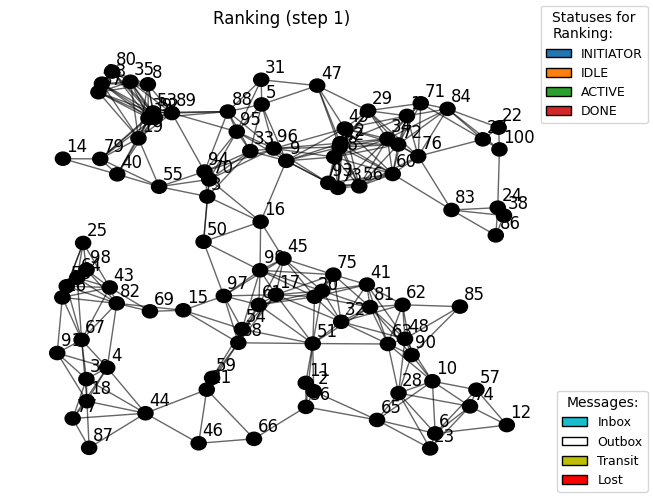

In [120]:
%matplotlib inline
from matplotlib import pyplot as plt
from pydistsim import NetworkGenerator, Simulation
from pydistsim.logging import set_log_level, LogLevels, enable_logger
from pydistsim.network.behavior import NetworkBehaviorModel
from pydistsim.gui import drawing as draw


net_gen = NetworkGenerator(100, directed=False)
net = net_gen.generate_random_network()
sim = Simulation(net, check_restrictions=True)
sim.algorithms = (Ranking,)
set_log_level(LogLevels.INFO)
enable_logger()

behaviour = NetworkBehaviorModel(message_ordering=True, message_loss_indicator=None, )
sim.network.behavioral_properties = behaviour

fig = draw.draw_current_state(sim)
fig



Ejecución y prueba de correctitud

In [121]:
sim.run()
#fig = draw.draw_current_state(sim)
#fig

values = []
for node in net.nodes():
    values.append((node.memory["rank"], node.memory["value"]))

piso = -1
for (rank, val) in sorted(values):
    if piso > val:
        assert False, "Error en el ranking: " + str(val)
    piso = val

2025-09-16 00:35:29.802 | INFO     | pydistsim.simulation:run:97 - Simulation has finished. There are no algorithms left to run. To run it from the start use sim.reset().
-1 3 3
3 3 4
4 3 7
7 4 9
9 5 12
12 6 20
20 7 37
37 8 47
47 9 52
52 10 83
83 11 83
83 12 98
98 13 104
104 14 111
111 16 114
114 16 115
115 17 119
119 18 123
123 19 129
129 20 143
143 21 165
165 23 166
166 23 171
171 24 178
178 25 179
179 25 179
179 27 180
180 29 193
193 29 200
200 30 206
206 31 211
211 32 227
227 33 229
229 34 245
245 35 256
256 36 293
293 37 299
299 38 308
308 39 314
314 40 319
319 41 321
321 42 322
322 43 327
327 44 334
334 45 337
337 46 338
338 47 346
346 48 382
382 49 387
387 50 389
389 51 399
399 52 419
419 53 443
443 54 449
449 55 466
466 56 476
476 57 480
480 58 488
488 59 491
491 60 494
494 61 502
502 62 506
506 62 517
517 63 517
517 65 519
519 66 533
533 67 538
538 68 547
547 69 556
556 70 558
558 71 559
559 72 570
570 73 573
573 74 579
579 75 592
592 76 607
607 77 621
621 78 626
626 78 633
63

In [88]:
sim.reset()
plt.close()

## Demostración de correctitud

El algoritmo propuesto se asemeja al protocolo Shout, si bien incorpora una segunda etapa de flooding que comienza localmente en cada nodo x una vez que sabe quiénes son sus vecinos en el spanning tree generado. Puede que los vecinos a los que les envíe el mensaje de flooding aún no conozcan enteramente el spanning tree, pero en ese caso el vecino (llamémosle y) guardará localmente v(x) para que, cuando sí sepa quienes son sus vecinos respectivos, comience el flooding de v(y) y continue con el flooding de v(y).

El algoritmo aprovecha el hecho de que en el flooding de un árbol bidireccional, cada mensaje de de flooding le llega a cada nodo exactamente una vez (pues no vuelve por donde vino, y al no haber ciclos no puede revisitar un nodo ya visitado).

#### El algoritmo termina
El algoritmo solo podría entrar en un loop si un mensaje de flooding quedara dando vueltas en un ciclo. Sin embargo esto no es posible, pues estos mensajes se envían solo a traves de los enlaces del spanning tree construido. La existencia de un ciclo en ese grafo implicaría que el spanning tree no es un árbol, lo cual es absurdo y se prueba por correctitud del algoritmo Shout.


#### Cuando los nodos finalizan con el intercambio de mensajes, cada nodo sabe en qué posición se encuentra
    Lema 1: Todos los nodos ejecutan flooding
....

    Lema 2: A cada nodo le llega exactamente una vez el flooding de cada otro nodo
Probar con lema 1


Luego, se desprende del lema 2 que, al contar la cantidad de mensajes "value" menores a mi valor, lo que estoy contando es en realidad la cantidad de valores de los nodos del grafo que son menores al mío, pues me llega exactamente un mensaje "value" por cada otro nodo de la red. Es decir, el registro ranking contiene mi posición en el ranking del grafo.

## Análisis de complejidad


#### En tiempo
Generación de spanning tree
Flooding: n*d (cada nodo tiene que hacer llegar su flooding a un diametro a lo sumo de d links)

#### En cantidad de mensajes
Generación de spanning tree
Flooding: n*(m-1), si cada nodo hace flooding por una subred que tiene a lo sumo m-1 links